In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39536")
client

Client Scheduler: tcp://127.0.0.1:39536 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 60 Memory: 254.00 GB


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar
import os.path as op
import os
import xrft
import gsw
import time
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'

In [5]:
year = 1963

grav = 9.81
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ystart = -15
yend = 50

mchunk = 1
xchunk = 250
ychunk = 400
schunk = -1

In [6]:
ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (24,year)), 
                     grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
#                      iters=943920,
                     prefix=['diag_ocnSnap'], delta_t=2e2,
                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                          YG=slice(ystart-12**-1,yend+2*12**-1)
                         ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

In [7]:
dsmn = xr.open_dataset(op.join(savedir,'%4d/Dyn_membs_0000943920.nc' % year), 
                       ).chunk({'nmemb':mchunk,'sig':schunk,'sigp1':schunk,
                                'XC':xchunk,'XG':xchunk,
                                'YC':ychunk,'YG':ychunk})
dsz = xr.open_dataset(op.join(savedir,'%4d/Zs_membs_0000943920.nc' % year), 
                     ).chunk({'nmemb':mchunk,'sig':schunk,'sigp1':schunk,
                              'XC':xchunk,'XG':xchunk,
                              'YC':ychunk,'YG':ychunk})
dsep = xr.open_dataset(op.join(savedir,'%4d/E-P_flux_0000943920.nc' % year)
                      ).chunk({'sig':schunk,'sigp1':schunk,
                               'XC':xchunk,'XG':xchunk,
                               'YC':ychunk,'YG':ychunk})

grid = Grid(dsep, periodic=['X'], 
            coords={'Z':{'center':'sig','outer':'sigp1'},
                   'Y':{'center':'YC','left':'YG'},
                   'X':{'center':'XC','left':'XG'}}
           )
dsep

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 783, YG: 783, sig: 60, sigp1: 61)
Coordinates:
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0
  * YC       (YC) float32 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XG       (XG) float32 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * YG       (YG) float32 -15.041634 -14.9583 -14.874967 ... 50.041702 50.125034
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sigp1    (sigp1) float64 19.75 20.25 20.76 21.27 ... 48.73 49.24 49.75 50.25
Data variables:
    e00      (YC, XG, sig) float64 dask.array<chunksize=(400, 250, 60), meta=np.ndarray>
    e01      (YC, XG, sig) float64 dask.array<chunksize=(400, 250, 60), meta=np.ndarray>
    e10      (YG, XC, sig) float64 dask.array<chunksize=(400, 250, 60), meta=np.ndarray>
    e11      (YG, XC, sig) float64 dask.array<chunksize=(400, 250, 60), meta=np.ndarray>
    e20      (YC, XC, sig) float64 dask.array<chunksize=(400, 250, 60), meta=np.ndarray>
    e21      (YC, XC, sig) float64 dask.array<chunksize=(400, 250, 60), meta=np.ndarray>

In [8]:
fC = xr.apply_ufunc(gsw.f, dsmn.YC)
fG = xr.apply_ufunc(gsw.f, dsmn.YG)
buoyb = -grav * dsmn.sig * rhoConst**-1
buoybp1 = -grav * dsmn.sigp1 * rhoConst**-1
sigma = dsz.dzetaF * -grid.diff(buoybp1,'Z',boundary='fill')**-1
sigmay = dsz.dzetaFy * -grid.diff(buoybp1,'Z',boundary='fill')**-1
sigmax = dsz.dzetaFx * -grid.diff(buoybp1,'Z',boundary='fill')**-1

vhat = ((dsmn.vdz * -grid.diff(buoybp1,'Z',boundary='fill')**-1
        ).mean('nmemb',skipna=True) # vdz * db**-1 = v * dz/db = v * \sigma
        * sigmay.mean('nmemb',skipna=True)**-1
       )
uhat = ((dsmn.udz * -grid.diff(buoybp1,'Z',boundary='fill')**-1
        ).mean('nmemb',skipna=True) 
        * sigmax.mean('nmemb',skipna=True)**-1
       )

In [9]:
e00x = (grid.diff(sigmax.mean('nmemb')*dsep.e00*ds.dyG,'X') * ds.rA**-1 
        * sigma.mean('nmemb')**-1)
e10y = (grid.diff(sigmay.mean('nmemb')*dsep.e10*ds.dxG,
                  'Y',boundary='fill') * ds.rA**-1 
        * sigma.mean('nmemb')**-1)
e20b = (grid.interp(grid.diff(sigma.mean('nmemb')*dsep.e20,'Z',boundary='fill') 
                    * grid.diff(buoyb,'Z',boundary='fill')**-1,
                    'Z',boundary='fill') 
        * sigma.mean('nmemb')**-1)
    
e01x = (grid.diff(sigmax.mean('nmemb')*dsep.e01*ds.dyG,'X') * ds.rA**-1 
        * sigma.mean('nmemb')**-1)
e11y = (grid.diff(sigmay.mean('nmemb')*dsep.e11*ds.dxG,
                  'Y',boundary='fill') * ds.rA**-1 
        * sigma.mean('nmemb')**-1)
e21b = (grid.interp(grid.diff(sigma.mean('nmemb')*dsep.e21,'Z',boundary='fill') 
                    * grid.diff(buoyb,'Z',boundary='fill')**-1,
                    'Z',boundary='fill') 
        * sigma.mean('nmemb')**-1)

Eu = e00x + e10y + e20b
Ev = e01x + e11y + e21b
Eu

<xarray.DataArray (YC: 783, XC: 1000, sig: 60)>
dask.array<add, shape=(783, 1000, 60), dtype=float64, chunksize=(399, 249, 58), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0
    rA       (YC, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>

In [10]:
vort = (grid.diff(vhat*ds.dyC,'X') 
        - grid.diff(uhat*ds.dxC,'Y',boundary='fill')
       ) * ds.rAz**-1
Pi = ((grid.interp(grid.interp(vort,'X'),'Y',boundary='fill') + fC)
      * sigma.mean('nmemb',skipna=True)**-1)
PVpx = sigma.mean('nmemb')**-1 * Eu
PVpy = -sigma.mean('nmemb')**-1 * Ev
Pi

<xarray.DataArray (YC: 783, XC: 1000, sig: 60)>
dask.array<mul, shape=(783, 1000, 60), dtype=float64, chunksize=(398, 248, 60), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0

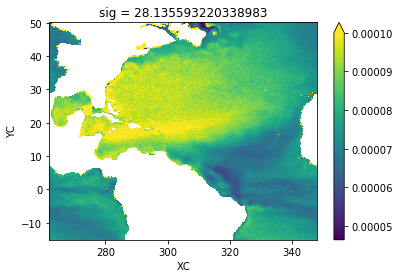

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/distributed/comm/tcp.py", line 188, in read
    n_frames = await stream.read_bytes(8)
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/distributed/client.py", line 1163, in _handle_report
    msgs = await self.scheduler_comm.comm.read()
  File "/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/distributed/comm/tcp.py", line 208, in read
    convert_stream_closed_error(self, e)
  File "/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/distributed/comm/tcp.py", line 123, in convert_stream_closed_error
    raise CommClosedError("in %s: %s" % (obj, exc))
distributed.comm.core.CommClosedError: in <closed TCP>: Stream

In [24]:
(sigma.mean('nmemb')**-1).isel(sig=16).plot(vmax=1e-4)

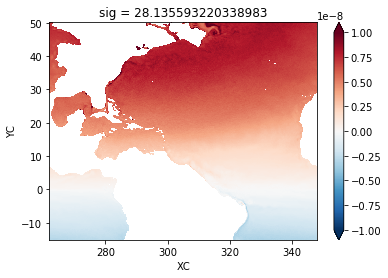

In [17]:
Pi.isel(sig=16).plot(vmax=1e-8)

In [18]:
Pix = grid.diff(Pi*grid.interp(ds.dyG,'X'),'X') * ds.rAw**-1
Piy = grid.diff(Pi*grid.interp(ds.dxG,'Y',boundary='fill'),
                'Y',boundary='fill') * ds.rAs**-1
Piy

<xarray.DataArray (YG: 783, XC: 1000, sig: 60)>
dask.array<mul, shape=(783, 1000, 60), dtype=float64, chunksize=(397, 248, 60), chunktype=numpy.ndarray>
Coordinates:
  * YG       (YG) float32 -15.041634 -14.9583 -14.874967 ... 50.041702 50.125034
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0
    dxG      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dyC      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAs      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>

In [19]:
kappax = -PVpx * grid.interp(Pix,'X')**-1
kappay = -PVpy * grid.interp(Piy,'Y',boundary='fill')**-1
kappax

<xarray.DataArray (YC: 783, XC: 1000, sig: 60)>
dask.array<mul, shape=(783, 1000, 60), dtype=float64, chunksize=(398, 246, 58), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 20.0 20.51 21.02 21.53 ... 48.47 48.98 49.49 50.0
    rA       (YC, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>

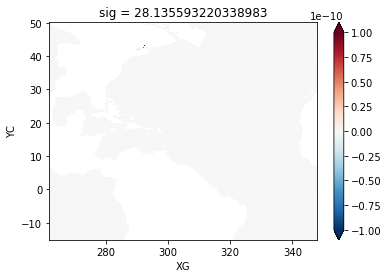

In [43]:
Pix.isel(sig=16).plot(vmax=1e-12)

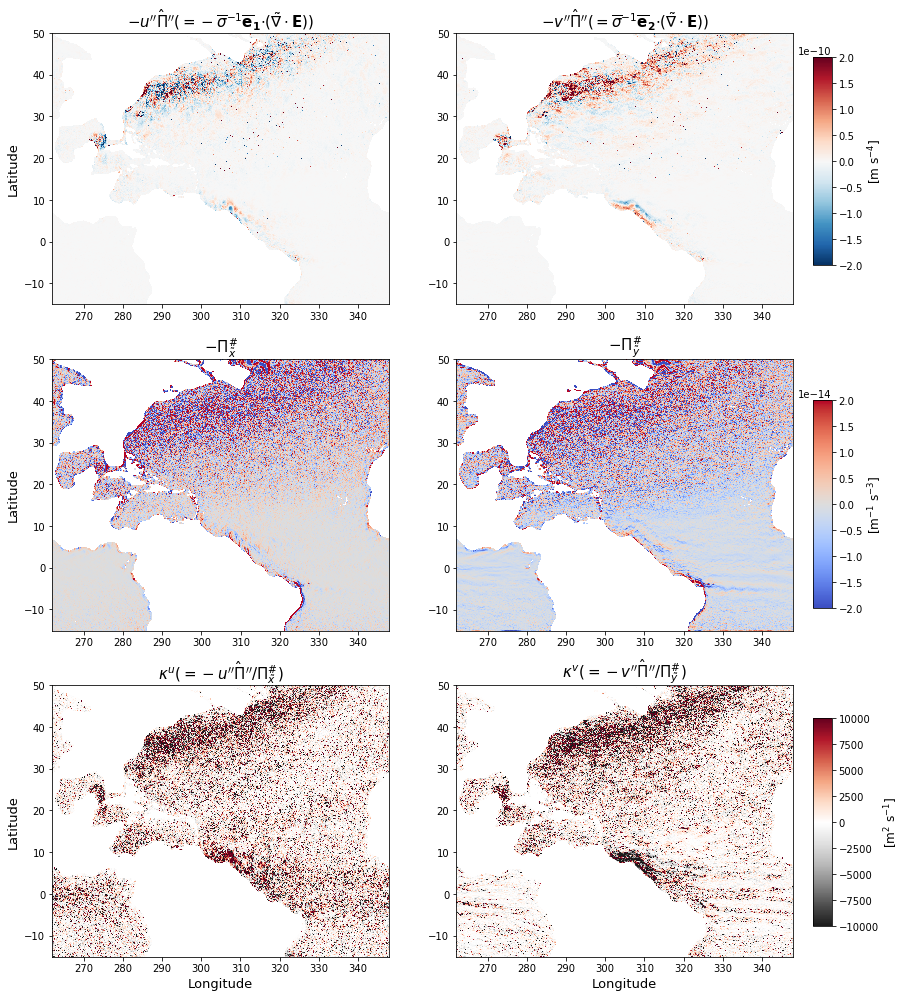

In [20]:
fig, axes = plt.subplots(figsize=(14,17), nrows=3, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(dsep.XC, dsep.YC, -PVpx.isel(sig=16), 
                           vmin=-2e-10, vmax=2e-10, cmap='RdBu_r', rasterized=True)
im1 = axes[0,1].pcolormesh(dsep.XG, dsep.YC, -PVpy.isel(sig=16), 
                           vmin=-2e-10, vmax=2e-10, cmap='RdBu_r', rasterized=True)
im2 = axes[1,0].pcolormesh(dsep.XG, dsep.YC, -Pix.isel(sig=16), 
                           vmin=-2e-14, vmax=2e-14, cmap='coolwarm', rasterized=True)
im3 = axes[1,1].pcolormesh(dsep.XC, dsep.YG, -Piy.isel(sig=16), 
                           vmin=-2e-14, vmax=2e-14, cmap='coolwarm', rasterized=True)
im4 = axes[2,0].pcolormesh(dsep.XC, dsep.YC, kappax.isel(sig=16), 
                           vmax=1e4, vmin=-1e4, cmap='RdGy_r', rasterized=True)
im5 = axes[2,1].pcolormesh(dsep.XC, dsep.YC, kappay.isel(sig=16), 
                           vmax=1e4, vmin=-1e4, cmap='RdGy_r', rasterized=True)

axes[0,0].set_title(r"$-\hat{u''\Pi''} (= -\overline{\sigma}^{-1}\overline{\bf e}_1$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=15)
axes[0,1].set_title(r"$-\hat{v''\Pi''} (= \overline{\sigma}^{-1}\overline{\bf e}_2$"
                    + r"$\cdot(\tilde{\nabla}\cdot{\bf E}))$", 
                    fontsize=15)
axes[1,0].set_title(r"$-\Pi^\#_\tilde{x}$", fontsize=15)
axes[1,1].set_title(r"$-\Pi^\#_\tilde{y}$", 
                    fontsize=15)
axes[2,0].set_title(r"$\kappa^u (= -\hat{u''\Pi''}/\Pi^\#_\tilde{x})$", 
                    fontsize=15)
axes[2,1].set_title(r"$\kappa^v (= -\hat{v''\Pi''}/\Pi^\#_\tilde{y})$", 
                    fontsize=15)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86)
# cbaxes = fig.add_axes([0.2, 0.08, 0.6, 0.01]) 
cbax0 = fig.add_axes([0.88, 0.69, 0.018, 0.17]) 
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m s$^{-4}$]", fontsize=12)
cbax2 = fig.add_axes([0.88, 0.41, 0.018, 0.17]) 
cbar2 = fig.colorbar(im2, orientation='vertical', cax=cbax2)
cbar2.set_label(r"[m$^{-1}$ s$^{-3}$]", fontsize=12)
cbax4 = fig.add_axes([0.88, 0.15, 0.018, 0.17]) 
cbar4 = fig.colorbar(im4, orientation='vertical', cax=cbax4)
cbar4.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(savedir,'Figures/PV_flux_1963-Dec-26.pdf'))